In [1]:
import shutil, os, random

import tensorflow as tf

import tensorflow.keras.utils as utils

from tensorflow.keras.models import Model

import tensorflow.keras.layers as layers

from tensorflow.keras.applications import MobileNet

In [ ]:
origin = "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F"

orifile = "kagglecatsanddogs_5340.zip"

origin = os.path.join(origin, orifile)

tenori(origin)

In [3]:
rooter = "/tmp/datasets/petimages"

os.listdir(rooter)

['cats', 'dogs']

In [4]:
def imroot(root):

  i = 0
  for item in os.listdir(root):
    roti = os.path.join(root, item)
    try:
      inputi = open(roti, "rb")
      images = tf.compat.as_bytes("JFIF") in inputi.peek(10)
    finally:
      inputi.close()

    if not images:
      i += 1
      os.remove(roti)

  return i

imroot(os.path.join(rooter, "cats"))

759

In [5]:
imroot(os.path.join(rooter, "dogs"))

831

In [6]:
i = len(os.listdir(os.path.join(rooter, "cats")))

j = len(os.listdir(os.path.join(rooter, "dogs")))

i + j

23412

In [ ]:
subset = "both"; label = "binary"

image = (160, 160); split = 0.3; random = 128

unseet = 10

orifile = utils.image_dataset_from_directory(
  rooter,
  seed = unseet,
  subset = subset,
  image_size = image,
  label_mode = label,
  batch_size = random,
  validation_split = split
)

train, testi = orifile

In [8]:
labeler = train.class_names

labeler

['cats', 'dogs']

In [9]:
relater = lambda i, l : (tf.cast(tf.math.divide(i, 255.0), tf.float32), l)

train = train.map(relater).cache().prefetch(1)

testi = testi.map(relater)

In [10]:
class Helper(Model):
  def __init__(self):
    super(Helper, self).__init__()
    self.flip_left_right = layers.RandomFlip()
    self.random_rotation = layers.RandomRotation(factor=0.4)
    self.random_translation = layers.RandomTranslation(height_factor=0.2, width_factor=0.2)
    self.random_size = layers.RandomZoom(height_factor=0.2)

  def call(self, i):
    x = self.flip_left_right(i)
    x = self.random_translation(x)
    x = self.random_translation(x)
    x = self.random_size(x)
    return x

imager = Helper()

train = train.map(lambda i, l : (imager(i), l))

testi = testi.map(lambda i, l : (imager(i), l))

In [11]:
len(train), len(testi)

(129, 55)

In [12]:
train = train.take(13); testi = testi.take(8)

len(train), len(testi)

(13, 8)

In [ ]:
from tensorflow.keras.applications import MobileNet

inputs = layers.Input((160, 160, 3))

intnet = MobileNet(weights="imagenet", include_top=False, input_tensor=inputs)

intnet.trainable = False

x = layers.GlobalAveragePooling2D()(intnet.output)

output = layers.Dense(1, activation='sigmoid')(x)

model = Model(inputs, output)

In [14]:
model.compile(optimizer="adam", loss='binary_crossentropy', metrics=["accuracy"])

In [ ]:
epochs = 10

plot = model.fit(train, validation_data=testi, epochs=epochs)

In [16]:
model.evaluate(train, verbose=0)

[0.26410797238349915, 0.885817289352417]

In [17]:
model.evaluate(testi, verbose=0)

[0.27894771099090576, 0.87109375]

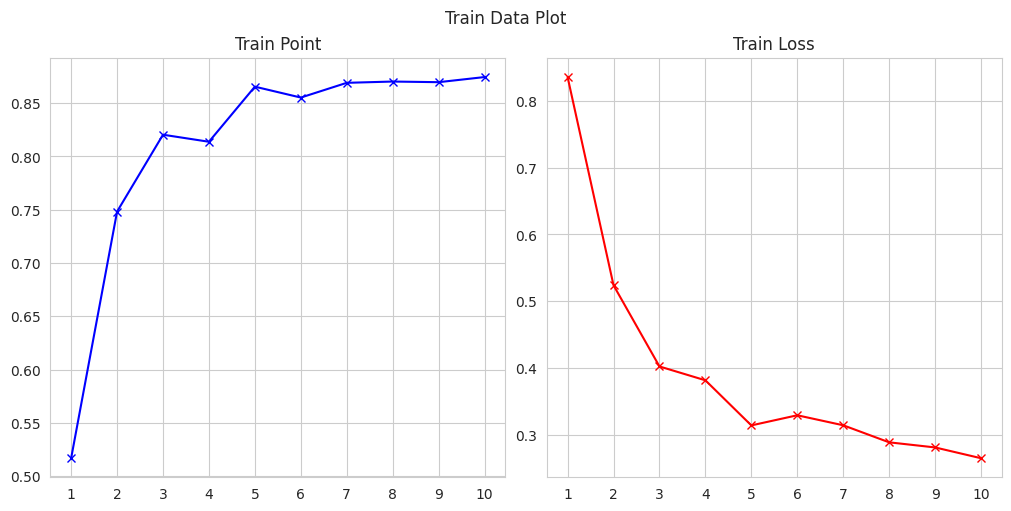

In [18]:
plot = Helplot(plot)

plot.trainplot

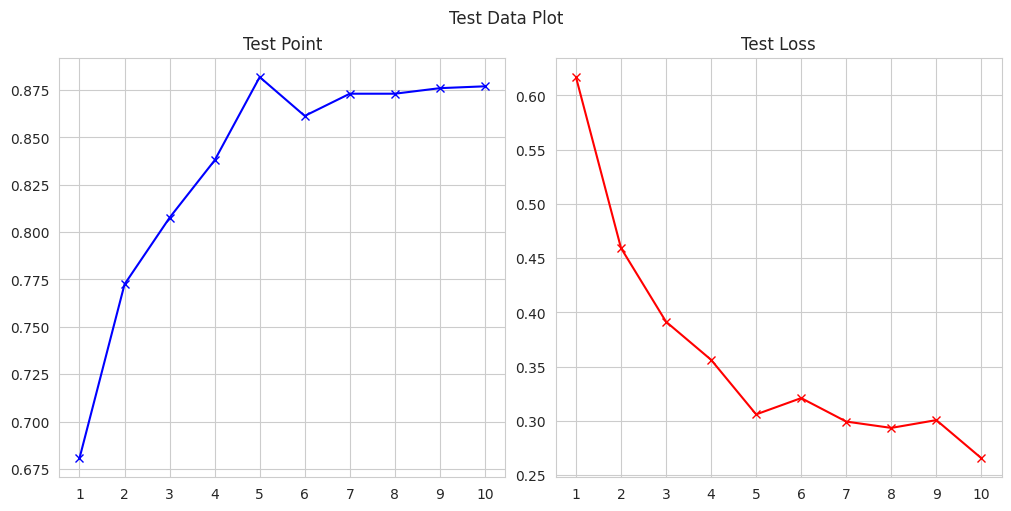

In [19]:
plot.testiplot

In [20]:
import os

molder = "/content/model"

tf.saved_model.save(model, molder)

### ```Optional 0```

In [21]:
meta = lambda filepath : os.path.getsize(filepath) / float(2**20)

In [22]:
tflite = tf.lite.TFLiteConverter

tflite_model = tflite.from_saved_model(molder)

In [23]:
optim = [tf.lite.Optimize.DEFAULT]

tflite_model.optimizations = optim

In [24]:
tflite_model.inference_input_type, tflite_model.inference_output_type

(tf.float32, tf.float32)

In [25]:
import pathlib

tflite_model = tflite_model.convert()

tflite_model_file = pathlib.Path("modelite.tflite")

tflite_model_file.write_bytes(tflite_model)

3381112

In [26]:
round(meta("/content/modelite.tflite"), 3)

3.224

In [27]:
interpreter = tf.lite.Interpreter(model_path="/content/modelite.tflite")

interpreter.get_signature_list()

{'serving_default': {'inputs': ['input_1'], 'outputs': ['dense']}}

In [28]:
clasilite = interpreter.get_signature_runner('serving_default')

clasilite

In [29]:
cats = "/tmp/datasets/petimages/cats"

catest = os.path.join(cats, os.listdir(cats)[0])

catest

'/tmp/datasets/petimages/cats/5174.jpg'

In [30]:
i = utils.load_img(catest, target_size=(160, 160))

i = utils.img_to_array(i)

i = tf.expand_dims(i, axis=0)

i = tf.cast(i / 255.0, tf.float32)

In [31]:
reclat = clasilite(input_1=i)['dense']

labeler[round(reclat.tolist()[0][0])]

'cats'

### ```Optional 1```

In [ ]:
model.save("/content/modelite.h5")

In [33]:
motest = tf.keras.models.load_model("/content/modelite.h5", compile=False)

def output(t, input_shape=(160, 160, 3)):
  i = utils.load_img(t, target_size=input_shape)
  i = utils.img_to_array(i)
  i = tf.expand_dims(i, axis=0)
  i = tf.cast(i / 255.0, tf.float32)
  j = motest.predict(i, verbose=0)
  result = labeler[round(j.tolist()[0][0])]
  return result

In [34]:
cats = "/tmp/datasets/petimages/cats"

catest = os.listdir(cats)[:5]

catest = [os.path.join(cats, i) for i in catest]

[output(i) for i in catest]

['cats', 'cats', 'cats', 'cats', 'cats']

In [35]:
dogs = "/tmp/datasets/petimages/dogs"

dotest = os.listdir("/tmp/datasets/petimages/dogs")[:5]

dotest = [os.path.join(dogs, i) for i in dotest]

[output(i) for i in dotest]

['dogs', 'dogs', 'dogs', 'dogs', 'dogs']